# Comparison between with and without offset model

Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeBCNN
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 100 forward passes, 119.48s elapsed
Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeBCNN
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 100 forward passes, 117.30s elapsed


C:\Users\Henry\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Henry\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Henry\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Henry\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Henry\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
C:\Users\Henry\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2366: DeprecationWarning: Using or importing the ABCs from

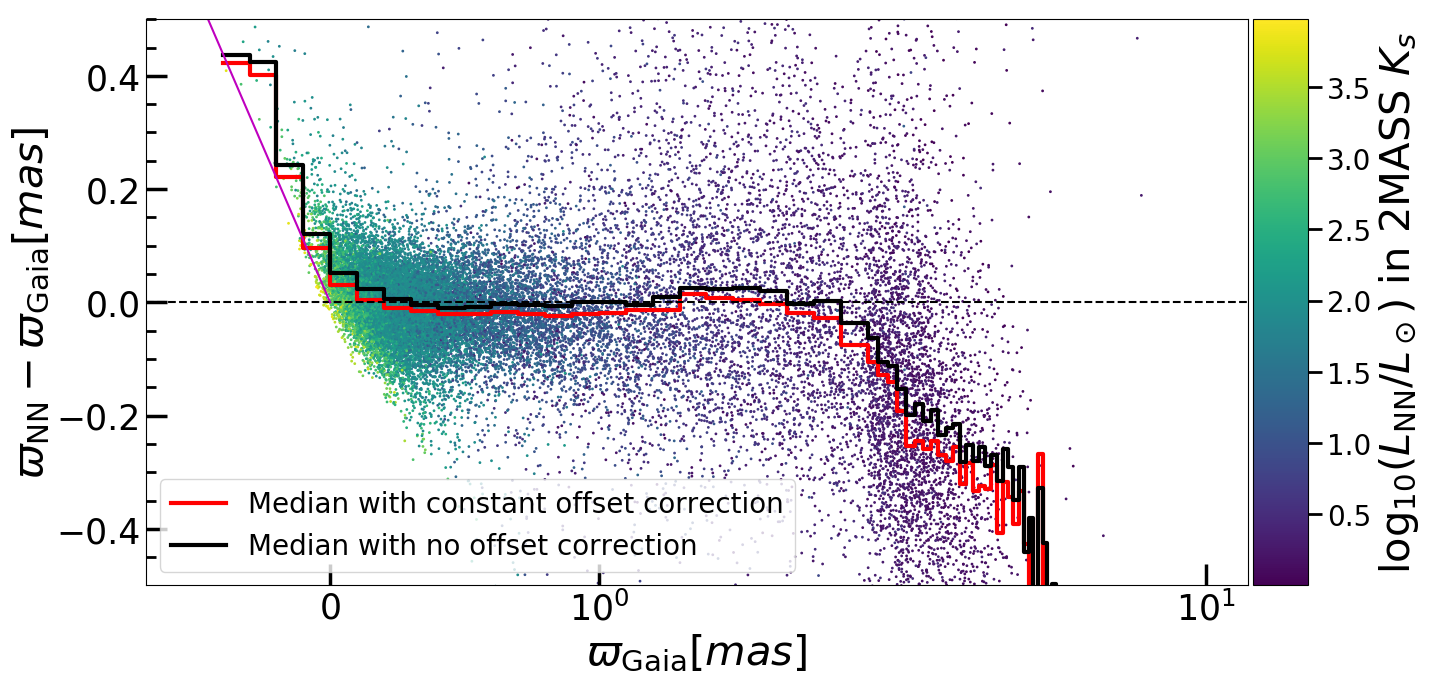

In [1]:
%matplotlib inline
from astroNN.models import load_folder
from astroNN.nn.numpy import median_absolute_percentage_error as mape
from astroNN.gaia import mag_to_fakemag, fakemag_to_pc, fakemag_to_logsol, fakemag_to_parallax
import h5py
import numpy as np
import pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

with h5py.File('gaia_dr2_test.h5', 'r') as F:
    spectra = np.array(F['spectra'])
    parallax = np.array(F['parallax'])
    parallax_err = np.array(F['parallax_err'])
    corrected_K = np.array(F['corrected_K'])
    
net = load_folder("astroNN_constant_model_reduced")
pred, pred_error = net.test(spectra)

net2 = load_folder("astroNN_no_offset_model")
pred2, pred2_error = net2.test(spectra)

logsol = fakemag_to_logsol(pred[:, 0])

above_solar = (logsol > 0)

number_bin = 55
low_parallax = -0.5
high_parallax= 5
median_diff = []
median_diff2 = []
spaces_dist = np.linspace(low_parallax, high_parallax, number_bin+1)

residue = (fakemag_to_parallax(pred[:, 0], corrected_K).value - parallax - 0.0525)[above_solar]
residue2 = (fakemag_to_parallax(pred2[:, 0], corrected_K).value - parallax)[above_solar]

for i in range(number_bin):
    idx = ((parallax[above_solar]<spaces_dist[i+1]) & (parallax[above_solar]>spaces_dist[i]))
    median_diff.append(np.median(residue[idx]))
    median_diff2.append(np.median(residue2[idx]))

f, ax = plt.subplots(1, figsize=(15,7.5), dpi=100)
ax.semilogx(spaces_dist[:-1], np.array(median_diff), ls='steps-post', linewidth=3., c='r', label='Median with constant offset correction')
ax.semilogx(spaces_dist[:-1], np.array(median_diff2), ls='steps-post', linewidth=3., c='k', label='Median with no offset correction')
mappable = ax.scatter(parallax[above_solar], residue, c=logsol[above_solar], s=1., rasterized=True)
ax.set_xscale('symlog')
ax.axhline(0., ls='--', c='k')
ax.plot([0, -0.5], [0.0, 0.55], c='m')
ax.set_xlabel(r'$ \varpi_{\mathrm{Gaia}} [mas]$', fontsize=30)
ax.set_ylabel(r'$\varpi_{\mathrm{NN}} - \varpi_{\mathrm{Gaia}} [mas]$', fontsize=30)
ax.set_ylim(-0.5, 0.5)
ax.legend(loc='best', fontsize=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"$\log_{10} (L_\mathrm{NN} /L_\odot)$" + " in 2MASS " + r"$K_{s}$", size=30)
ax.minorticks_on()
ax.tick_params(labelsize=25, width=2.5, length=15, which='major')
ax.tick_params(width=2, length=7, which='minor')
ax.xaxis.set_tick_params(direction='in', which='both')
ax.yaxis.set_tick_params(direction='in', which='both')
# plt.savefig("result_offset_median.pdf")

# Get offset model posterior

Getting posterior from offset model is not trivial and the following code shows how to do it

**restart your ipython kernel everytime you run it**

In [1]:
import numpy as np

from astroNN.models import load_folder
from astroNN.config import keras_import_manager, cpu_gpu_check

cpu_gpu_check()
keras = keras_import_manager()
Model = keras.models.Model

net = load_folder("astroNN_constant_model")

input_tensor = net.get_layer("dense").input
output_tensor = net.get_layer("offset_output").output

model = Model(inputs=net.keras_model.input, outputs=output_tensor)

offset = model.predict({'input': np.ones((1000, 7518, 1)), 'labels_err': np.ones((1000, 1)), 'input_err': np.ones((1000, 7518, 1))}) * 1.4124689064768827 * 1000
mean = np.mean(offset)
std = np.std(offset)
print(f"Offset: {mean:.1f}+/-{std:.1f}")

Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeDR14GaiaDR2BCNN
Offset: 52.0+/-2.4
